In [63]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install psycopg2-binary
    !pip install h5py==2.10.0
    !pip install -U imbalanced-learn  
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [ ]:
# !pip uninstall xgboost
# !pip install xgboost==0.9
# import xgboost as xgb
# xgb.__version__

In [43]:
import psycopg2
import pandas.io.sql as psql
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap
import eli5
from eli5.sklearn import PermutationImportance


# 모델 관련
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score

# 평가지표
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Error 생략
pd.options.mode.chained_assignment = None 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#한글 Font
import matplotlib as mpl
mpl.rc("font", family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

# 그래프 선명하게
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [58]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
db = psycopg2.connect(host='john.db.elephantsql.com', dbname='qnqtbswf',user='qnqtbswf',password='10BJ8vKMCewphIv0BeAf0-i8ZazkHzik',port=5432)
df = psql.read_sql('SELECT * FROM steamspy', db)
df = df[(df.positive_ratio != 0) & (df.positive_ratio != 1)]
#df.genre = df.genre.str.strip()
#df = df[(df['genre'] != 'Indie')]
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.shape

(19288, 16)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19288 entries, 0 to 19287
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   appid                       19288 non-null  int64  
 1   Game_name                   19288 non-null  object 
 2   developer                   19288 non-null  object 
 3   publisher                   19288 non-null  object 
 4   positive_review             19288 non-null  int64  
 5   negative_review             19288 non-null  int64  
 6   average_playtime_from_2009  19288 non-null  float64
 7   initial_price_KRW           19288 non-null  int64  
 8   language                    19288 non-null  object 
 9   genre                       19288 non-null  object 
 10  release_year                19288 non-null  int64  
 11  Korean_language_support     19288 non-null  int64  
 12  indie_game                  19288 non-null  int64  
 13  price_discount              192

In [28]:
Nan_index = df[df['price_group']=='NaN'].index
df = df.drop(index=Nan_index)
df.reset_index(drop=True, inplace=True)

In [29]:
df.loc[df['genre'] =='Action','genre']=1
df.loc[df['genre'] =='Adventure','genre']=2
df.loc[df['genre'] =='Casual','genre']=3
df.loc[df['genre'] =='Simulation','genre']=5
df.loc[df['genre'] =='Strategy','genre']=4
df.loc[df['genre'] =='RPG','genre']=6
df.loc[df['genre'] =='Racing','genre']=7
df.loc[df['genre'] =='Sports','genre']=8


df.loc[df['price_group'] =='만원이하','price_group']=1
df.loc[df['price_group'] =='만원~2만원','price_group']=2
df.loc[df['price_group'] =='2만원~ 3만원','price_group']=3
df.loc[df['price_group'] =='3만원~4만원','price_group']=4
df.loc[df['price_group'] =='4만원~5만원','price_group']=5
df.loc[df['price_group'] =='5만원~6만원','price_group']=6
df.loc[df['price_group'] =='6만원 이상','price_group']=7

df['genre'] = df['genre'].astype(int)
df['price_group'] = df['price_group'].astype(int)

In [35]:
# column 명 변경
df.rename(columns = {'Korean_language_support':'Korean', 'indie_game':'indie', 'price_discount':'discount'},inplace=True)

In [36]:
#Dataset 나누기
train, val = train_test_split(df, test_size=0.2, random_state=2)

train.shape, val.shape

((15428, 16), (3857, 16))

In [37]:
df['genre'].value_counts()

1    9110
2    4873
3    3438
5     634
4     520
6     455
7     194
8      61
Name: genre, dtype: int64

In [38]:
df['price_group'].value_counts()

1    10552
2     5386
3     2145
4      519
5      376
7      178
6      129
Name: price_group, dtype: int64

In [40]:
target = 'positive_ratio'
features = ['genre', 'Korean', 'indie', 'discount', 'price_group']

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

# X_test = test[features]
# y_test = test[target]

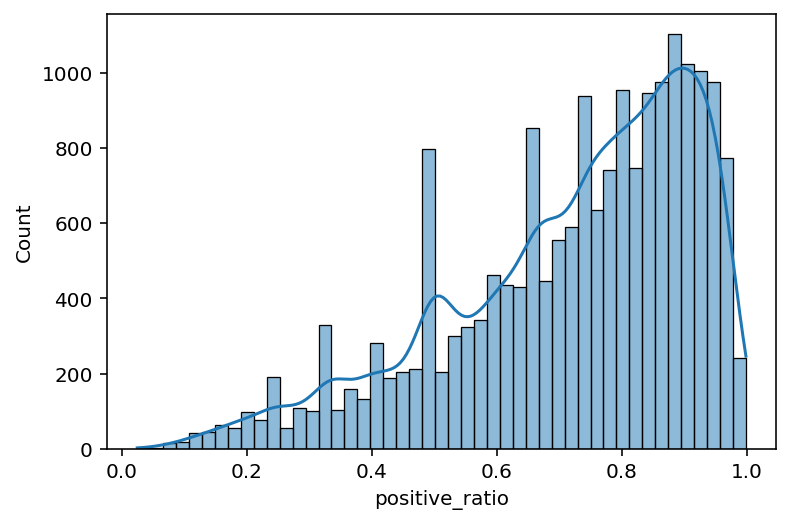

In [79]:
# Target variable 확인
sns.histplot(x='positive_ratio', data=df, kde=True)
plt.show()

## Model Test

Linear regression

In [54]:
linear_model = make_pipeline(
    #OrdinalEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    LinearRegression(n_jobs=-1))

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print('Score :', linear_model.score(X_val, y_val))
print('MAE :', mae)
print('MSE :', mse)
print('RMSE :', rmse)
print('R2 :', r2)

Score : 0.03143385378823227
MAE : 0.15642804329959875
MSE : 0.0372009852888795
RMSE : 0.19287556944537973
R2 : 0.03143385378823227


DecisionTree

In [53]:
DecisionTree = make_pipeline(
    #OrdinalEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    DecisionTreeRegressor(random_state=2))

DecisionTree.fit(X_train, y_train)

y_pred = DecisionTree.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print('Score :', DecisionTree.score(X_val, y_val))
print('MAE :', mae)
print('MSE :', mse)
print('RMSE :', rmse)
print('R2 :', r2)

Score : 0.058509329426097656
MAE : 0.15261708041122127
MSE : 0.03616106212531126
RMSE : 0.19016062191029787
R2 : 0.058509329426097656


RandomForests

In [55]:
RandomForests = make_pipeline(
    #OrdinalEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    RandomForestRegressor(random_state=2, n_jobs = -1))

RandomForests.fit(X_train, y_train)

y_pred = RandomForests.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print('Score :', RandomForests.score(X_val, y_val))
print('MAE :', mae)
print('MSE :', mse)
print('RMSE :', rmse)
print('R2 :', r2)

Score : 0.06161003083438821
MAE : 0.15243691423778016
MSE : 0.036041969435641925
RMSE : 0.18984722656821176
R2 : 0.06161003083438821


XGBoost

In [82]:
XGboost = make_pipeline(
    #OrdinalEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    XGBRegressor(random_state=2, n_jobs = -1))

XGboost.fit(X_train, y_train)

y_pred = XGboost.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print('Score :', XGboost.score(X_val, y_val))
print('MAE :', mae)
print('MSE :', mse)
print('RMSE :', rmse)
print('R2 :', r2)

Score : 0.05893140826701393
MAE : 0.15257713058971312
MSE : 0.03614485079187463
RMSE : 0.19011799176268043
R2 : 0.05893140826701393


## Hyperparameter Tunning

In [126]:
RandomForests = make_pipeline(
    #OrdinalEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    RandomForestRegressor(random_state=2, n_jobs = -1))

dists = {
    #'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
     'randomforestregressor__n_estimators': [200, 300, 400, 500], 
     'randomforestregressor__max_features': [None], 
    'randomforestregressor__max_depth': [5,10, 15, 20, 25, 30], 
    'randomforestregressor__min_samples_split': [2 ,4, 6, 8], 
    'randomforestregressor__min_samples_leaf': [1,2,3,4]
}


clf_rf = RandomizedSearchCV(
    estimator=RandomForests, 
    param_distributions=dists, 
    n_iter = 300,
    cv=5, 
    scoring='neg_root_mean_squared_error' ,
    verbose=3,
    random_state = 2,
    n_jobs=-1)

clf_rf.fit(X_train, y_train)
print('최적 하이퍼파라미터: ', clf_rf.best_params_)
print('best score', clf_rf.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
최적 하이퍼파라미터:  {'randomforestregressor__n_estimators': 300, 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': 5}
best score -0.1920385414259563


In [127]:
# 최적화 모델 성능 확인
best_model = clf_rf.best_estimator_
y_pred = best_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print('Score :', best_model.score(X_val, y_val))
print('MAE :', mae)
print('MSE :', mse)
print('RMSE :', rmse)
print('R2 :', r2)

Score : 0.06055642554546414
MAE : 0.15279180400832715
MSE : 0.03608243663037803
RMSE : 0.18995377498322594
R2 : 0.06055642554546403


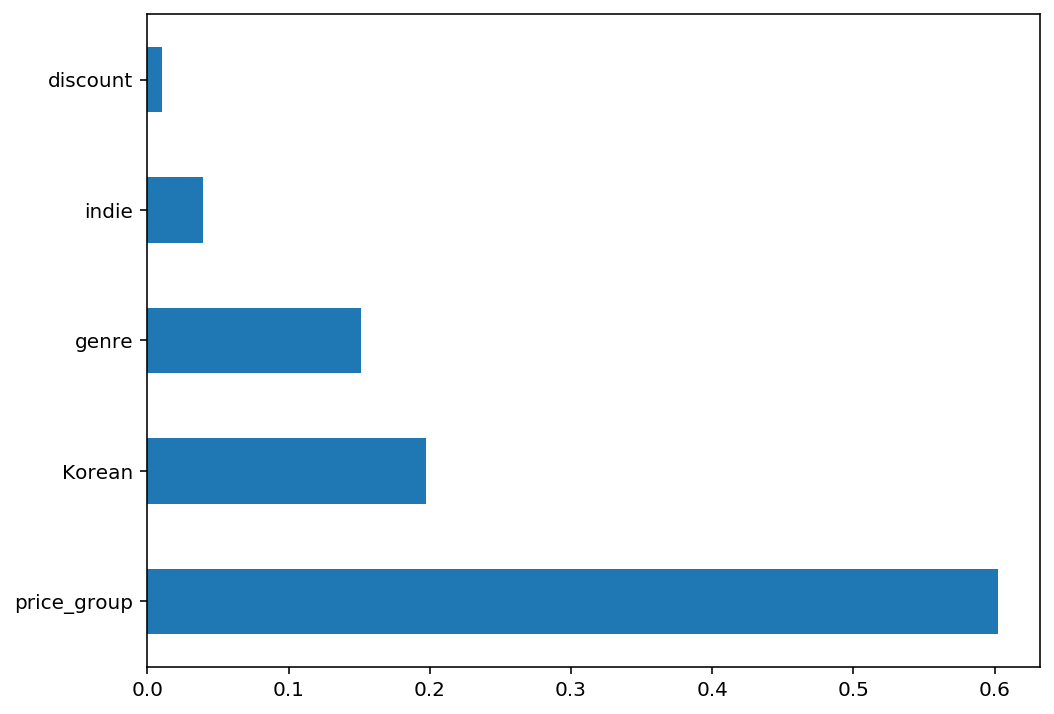

In [151]:
feat_importances = pd.Series(best_model.steps[2][1].feature_importances_, index=X_train.columns)
plt.figure(figsize=(8,6))
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [128]:
import pickle

with open('/content/drive/MyDrive/CodeStates/Section3/Section3_project/rf_model.pkl','wb') as pickle_file:
    pickle.dump(best_model, pickle_file)

In [129]:
# 모델 Test
import pickle

filename = '/content/drive/MyDrive/CodeStates/Section3/Section3_project/rf_model.pkl'
model = pickle.load(open(filename, 'rb'))
# features = ['genre', 'Korean', 'indie', 'discount', 'price_group']
model.predict([[1,0,0,0,3]])

array([0.76338855])